In [1]:
from pyabc import History
import pandas as pd
from ionchannelABC.utils import weighted_cv
from pyabc.weighted_statistics import weighted_mean
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:288: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:288: SyntaxWarning: assertion is always true, perhaps remove parentheses?


### Load history files

In [2]:
h_nyg_original = History('sqlite:///'+
                         '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/reported/nygren_ina_reported.db')

In [3]:
h_nyg_full = History('sqlite:///'+
                     '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/full/nygren_ina_full2.db')

In [4]:
h_cou_m = History('sqlite:///'+
                  '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/reported/courtemanche_mgate_reported.db')
h_cou_h = History('sqlite:///'+
                  '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/reported/courtemanche_hgate_reported.db')
h_cou_j = History('sqlite:///'+
                  '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/reported/courtemanche_jgate_reported.db')

history_cou_m_full = History('sqlite:///'+
                        '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/full/courtemanche_mgate_full.db')
history_cou_h_full = History('sqlite:///'+
                        '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/full/courtemanche_hgate_full.db')
history_cou_j_full = History('sqlite:///'+
                        '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/full/courtemanche_jgate_full.db')

In [5]:
h_sta = History('sqlite:///'+
                '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/standardised/standardised_ina_alt_full.db')

## Compare number of parameters

In [6]:
data = [['NYG',6,9],['COU',6,25],['STA',4,5]]

In [7]:
df = pd.DataFrame(data, columns = ['model', 'act', 'inact'])

In [8]:
df.inact = df.act+df.inact

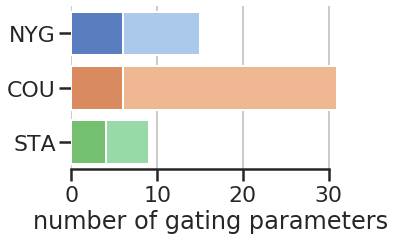

In [15]:
sns.set(style="ticks")
sns.set_context('poster')
sns.set_color_codes("pastel")

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


f, ax = plt.subplots(figsize=(5,3))


sns.barplot(x="inact", y="model", hue="model", data=df,
            palette="pastel", dodge=False)
            #label="inact", color="b")

sns.set_color_codes("muted")
sns.barplot(x="act", y="model", hue="model", data=df,
            palette="muted", dodge=False)
            #label="act", color="r")

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(xlabel="number of gating parameters")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [16]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/param_compare.pdf')

### Compare original and full datasets

In [50]:
df_nyg, w_nyg = h_nyg_original.get_distribution()

In [51]:
cv_nyg = weighted_cv(df_nyg, w_nyg, sample_size=2000)

In [52]:
model = ['NYG',]*len(cv_nyg)
data = ['ORIGINAL',]*len(cv_nyg)
frame = {'model': model, 'data': data, 'CV': cv_nyg}
df_nyg = pd.DataFrame(frame)

In [53]:
df_nyg_full, w_nyg_full = h_nyg_full.get_distribution()
cv_nyg_new = weighted_cv(df_nyg_full, w_nyg_full, sample_size=2000)
model = ['NYG',]*len(cv_nyg_new)
data = ['FULL',]*len(cv_nyg_new)
frame = {'model': model, 'data': data, 'CV': cv_nyg_new}
df_nyg_new = pd.DataFrame(frame)

In [54]:
old_vs_new = pd.concat([df_nyg, df_nyg_new])

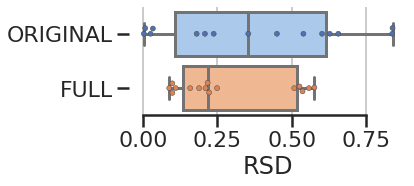

In [65]:
sns.set(style="ticks")
sns.set_context('poster')
sns.set_color_codes('pastel')

# Initialize the figure
f, ax = plt.subplots(figsize=(5, 2))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='CV', y='data', data=old_vs_new,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x='CV', y='data', data=old_vs_new,
              dodge=True, linewidth=0.5
            )

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [13]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nyg_add_data.pdf')

In [66]:
diff = df_nyg_new.CV-df_nyg.CV
ss.wilcoxon(diff)

WilcoxonResult(statistic=40.0, pvalue=0.25598851167013814)

In [15]:
df_cou_m, w_m = h_cou_m.get_distribution()
df_cou_h, w_h = h_cou_h.get_distribution()
df_cou_j, w_j = h_cou_j.get_distribution()

In [16]:
cv_cou_m = weighted_cv(df_cou_m, w_m, sample_size=500)
cv_cou_h = weighted_cv(df_cou_h, w_h, sample_size=1000)
cv_cou_j = weighted_cv(df_cou_j, w_j, sample_size=2000)

cv_cou = pd.concat([cv_cou_m, cv_cou_h, cv_cou_j])
model = ['COU',]*len(cv_cou)
data = ['ORIGINAL',]*len(cv_cou)

In [17]:
frame = {'model': model, 'data': data, 'CV': cv_cou}
df_cou = pd.DataFrame(frame)

df_cou_m_full, w_m_full = history_cou_m_full.get_distribution()
df_cou_h_full, w_h_full = history_cou_h_full.get_distribution()
df_cou_j_full, w_j_full = history_cou_j_full.get_distribution()

cv_cou_m_full = weighted_cv(df_cou_m_full, w_m_full, sample_size=500)
cv_cou_h_full = weighted_cv(df_cou_h_full, w_h_full, sample_size=1000)
cv_cou_j_full = weighted_cv(df_cou_j_full, w_j_full, sample_size=2000)

cv_cou_full = pd.concat([cv_cou_m_full, cv_cou_h_full, cv_cou_j_full])
model = ['COU',]*len(cv_cou_full)
data = ['FULL',]*len(cv_cou_full)

frame = {'model': model, 'data': data, 'CV': cv_cou_full}
df_cou_new = pd.DataFrame(frame)

import scipy.stats as ss
diff = df_cou_new.CV-df_cou.CV
ss.wilcoxon(diff) # p = 0.007 significantly different from zero
ss.wilcoxon(diff, alternative='greater')

In [18]:
df = pd.concat([df_nyg, df_cou])

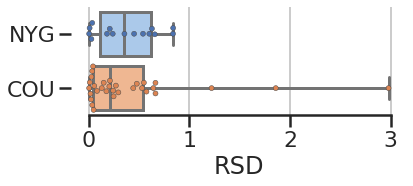

In [19]:
sns.set(style="ticks")
sns.set_context('poster')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 2))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='CV', y='model', data=df,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x='CV', y='model', data=df,
              linewidth=0.5)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [20]:
ss.mannwhitneyu(df[df.model=='NYG'].CV, df[df.model=='COU'].CV)

MannwhitneyuResult(statistic=213.0, pvalue=0.3280825529090522)

In [21]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/original_cv.pdf')

## Standardised model

In [22]:
df_sta, w_sta = h_sta.get_distribution()

In [23]:
eps_sta = h_sta.get_weighted_distances()

In [24]:
weighted_mean(eps_sta.distance, eps_sta.w)

0.7336410852909407

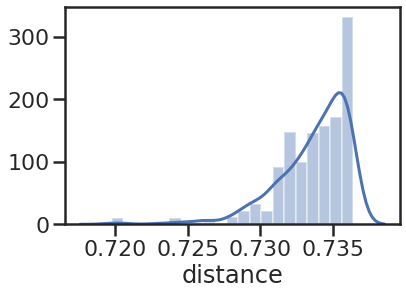

In [25]:
sns.distplot(eps_sta.distance, hist_kws={'weights': eps_sta.w})

In [26]:
cv_sta = weighted_cv(df_sta, w_sta, sample_size=500)

In [27]:
model = ['STA',]*len(cv_sta)
frame = {'model': model, 'CV': cv_sta}
df_sta = pd.DataFrame(frame)

In [28]:
df = pd.concat([df_nyg_new,df_cou,df_sta])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


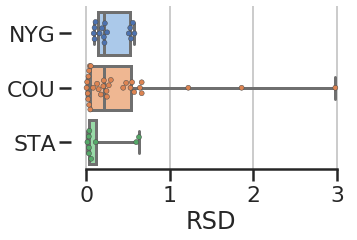

In [29]:
sns.set(style="ticks")
sns.set_context('poster')

# Initialize the figure
f, ax = plt.subplots(figsize=(5, 3))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='CV', y='model', data=df,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x='CV', y='model', data=df,
              linewidth=0.5)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [30]:
ss.mannwhitneyu(df[df.model=='NYG'].CV, df[df.model=='STA'].CV)

MannwhitneyuResult(statistic=34.0, pvalue=0.024548990804632777)

In [31]:
ss.mannwhitneyu(df[df.model=='COU'].CV, df[df.model=='STA'].CV)

MannwhitneyuResult(statistic=95.0, pvalue=0.07706228499282818)

In [32]:
ss.mannwhitneyu(df[df.model=='NYG'].CV, df[df.model=='COU'].CV)

MannwhitneyuResult(statistic=212.0, pvalue=0.31966123044490624)

In [33]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/compare_cv_full.pdf')

### Plot epsilon comparison

In [34]:
eps_cou_m = h_cou_m.get_weighted_distances()
eps_cou_h = h_cou_h.get_weighted_distances()
eps_cou_j = h_cou_j.get_weighted_distances()

In [35]:
# Create virtual COU epsilon dataset by summing
eps_cou = np.array([])
eps_cou = (np.array(eps_cou_m.sample(n=2000,axis=0,weights=eps_cou_m.w,replace=True).distance) +
           np.array(eps_cou_h.sample(n=2000,axis=0,weights=eps_cou_h.w,replace=True).distance) +
           np.array(eps_cou_j.sample(n=2000,axis=0,weights=eps_cou_j.w,replace=True).distance))

In [36]:
frame = {'model': 'COU', 'distance': eps_cou}
eps_cou = pd.DataFrame(frame)

In [37]:
eps_nyg = h_nyg_full.get_weighted_distances()

In [38]:
eps_nyg = eps_nyg.sample(n=2000,axis=0,weights=eps_nyg.w,replace=True).distance
eps_nyg = pd.DataFrame({'model': 'NYG', 'distance': eps_nyg})

In [39]:
eps_sta = eps_sta.sample(n=2000,axis=0,weights=eps_sta.w,replace=True).distance
eps_sta = pd.DataFrame({'model': 'STA', 'distance': eps_sta})

In [40]:
eps = pd.concat([eps_nyg,eps_cou,eps_sta])

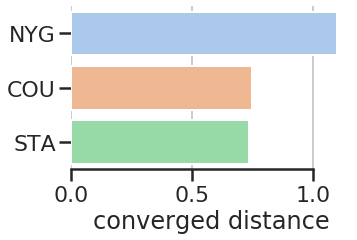

In [41]:
sns.set_context('poster')

f, ax = plt.subplots(figsize=(5,3))

sns.barplot(x="distance", y="model", data=eps, palette='pastel')

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="converged distance")
sns.despine(trim=True, left=True)

In [42]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/compare_eps.pdf')

## Plot simulation outputs

In [43]:
df_nyg, w_nyg = h_nyg_full.get_distribution()
df_cou_m, w_cou_m = h_cou_m.get_distribution()
df_cou_h, w_cou_h = h_cou_h.get_distribution()
df_cou_j, w_cou_j = h_cou_j.get_distribution()
df_sta, w_sta = h_sta.get_distribution()

In [44]:
from ionchannelABC.visualization import plot_sim_results

In [45]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)

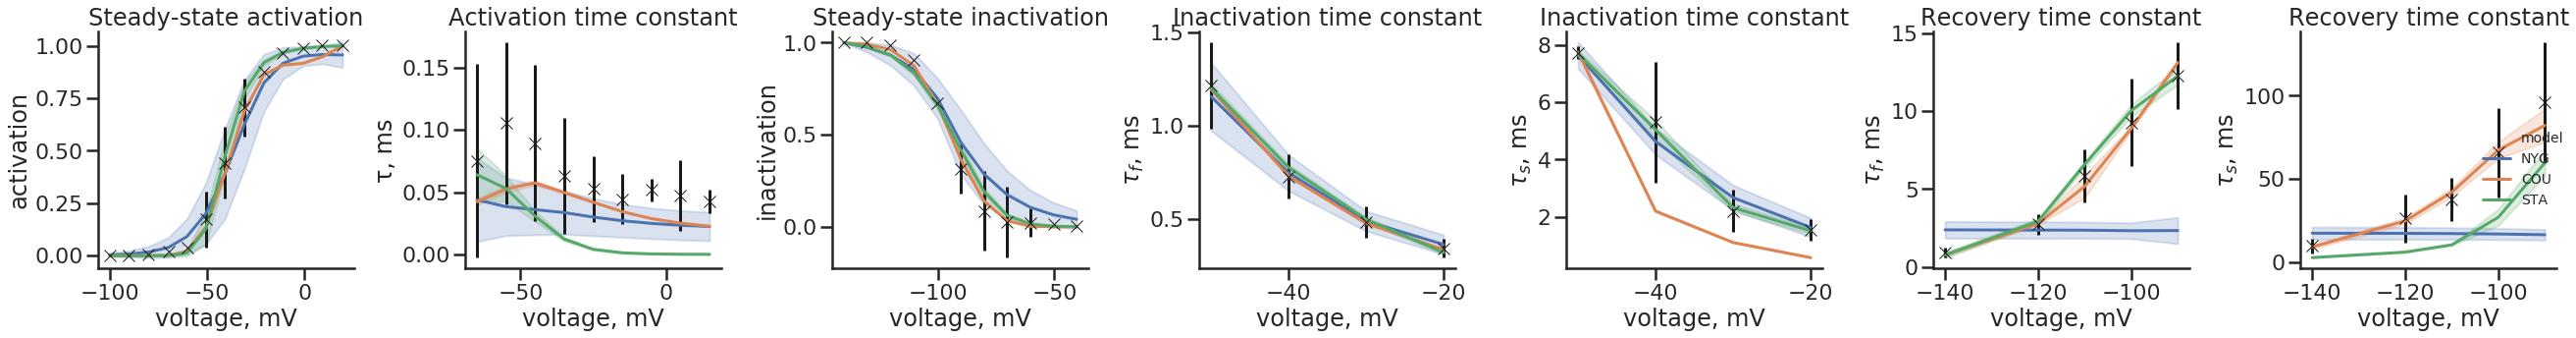

In [46]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/standardised_ina_alt.mmt'],
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_fast,
                     sakakibara_rec_slow,
                     temp_match_model = 4,
                     masks=[None,
                            [0,1]+[None,]*5,
                            [None,]*2+[2,3,None,5,None],
                            [None,]*4+[4,None,6],
                            None],
                     df=[df_nyg,
                         df_cou_m,
                         df_cou_h,
                         df_cou_j,
                         df_sta], 
                     w=[w_nyg,
                        w_cou_m,
                        w_cou_h,
                        w_cou_j,
                        w_sta])

xlabels = ["voltage, mV"]*7
ylabels = ["activation", "τ, ms", "inactivation",
           "$τ_f$, ms", "$τ_s$, ms", "$τ_f$, ms", "$τ_s$, ms"]
titles = ["Steady-state activation", "Activation time constant", "Steady-state inactivation",
          "Inactivation time constant", "Inactivation time constant",
          "Recovery time constant", "Recovery time constant"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax, t in zip(g.axes.flatten(), titles):
    ax.set_title(t)

plt.tight_layout()

In [48]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/compare_out.pdf')

### Compare SS and tau values

In [17]:
df_nyg, w_nyg = h_nyg_full.get_distribution()
df_cou_m, w_cou_m = h_cou_m.get_distribution()
df_cou_h, w_cou_h = h_cou_h.get_distribution()
df_cou_j, w_cou_j = h_cou_j.get_distribution()
df_sta, w_sta = h_sta.get_distribution()

In [18]:
import myokit
nyg = 'models/nygren_ina.mmt'
cou ='models/courtemanche_ina.mmt'
std = 'models/standardised_ina_alt.mmt'

In [19]:
v = np.arange(-140, 50, 0.5)

In [20]:
cou_vars = {'mi': 'ina.m_inf',
            'hi': 'ina.h_inf',
            'ji': 'ina.j_inf',
            'mt': 'ina.tau_m',
            'ht': 'ina.tau_h',
            'jt': 'ina.tau_j'}

In [21]:
nyg_vars = {'mi': 'ina.m_ss',
            'hi': 'ina.h_ss',
            'ji': 'ina.h_ss',
            'mt': 'ina.tau_m',
            'ht': 'ina.tau_h1',
            'jt': 'ina.tau_h2'}

In [22]:
from ionchannelABC.visualization import plot_variables

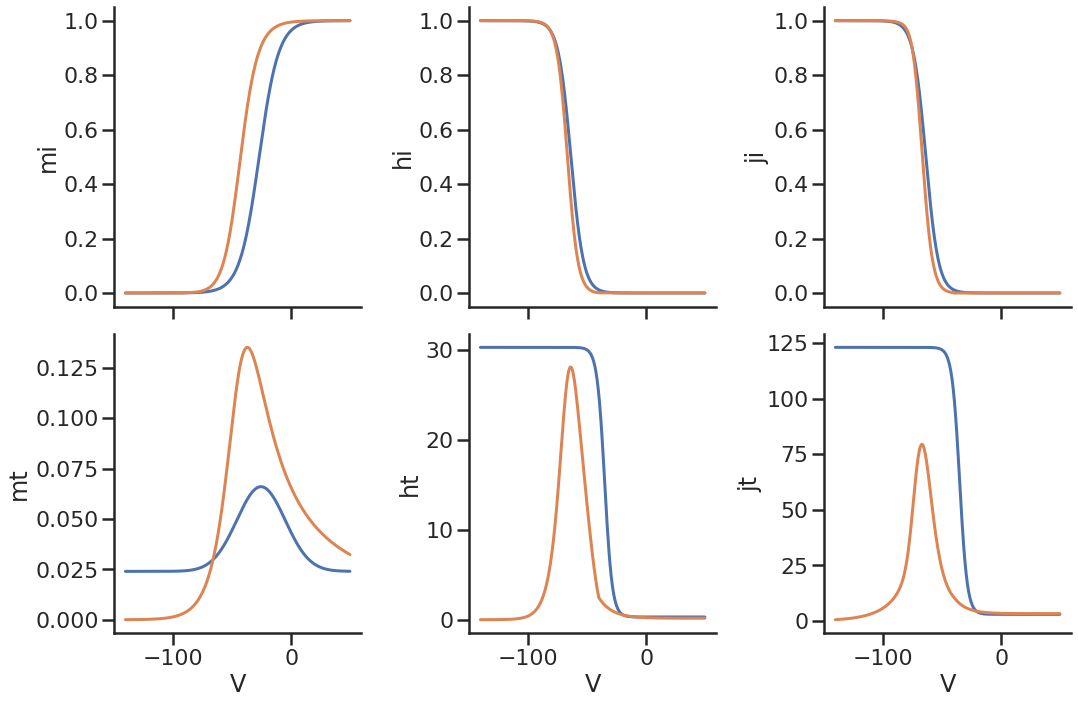

In [23]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, 
                       [nyg_vars, cou_vars], 
                       [nyg, cou],
                       figshape=(3,2))

In [24]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/ss_tau_original.pdf')

In [25]:
df_nyg_existing, w_nyg_existing = h_nyg_original.get_distribution()

In [26]:
nyg_pars_existing = df_nyg_existing.sample(n=100, weights=w_nyg_existing, replace=True)
nyg_pars_existing = nyg_pars_existing.set_index([pd.Index(range(100))])
nyg_pars_existing = nyg_pars_existing.to_dict(orient='records')

In [27]:
cou_pars_m = df_cou_m.sample(n=100, weights=w_cou_m, replace=True)
cou_pars_m = cou_pars_m.set_index([pd.Index(range(100))])
cou_pars_h = df_cou_h.sample(n=100, weights=w_cou_h, replace=True)
cou_pars_h = cou_pars_h.set_index([pd.Index(range(100))])
cou_pars_j = df_cou_j.sample(n=100, weights=w_cou_j, replace=True)
cou_pars_j = cou_pars_j.set_index([pd.Index(range(100))])
cou_pars = pd.concat([cou_pars_m,cou_pars_h,cou_pars_j],axis=1).to_dict(orient='records')

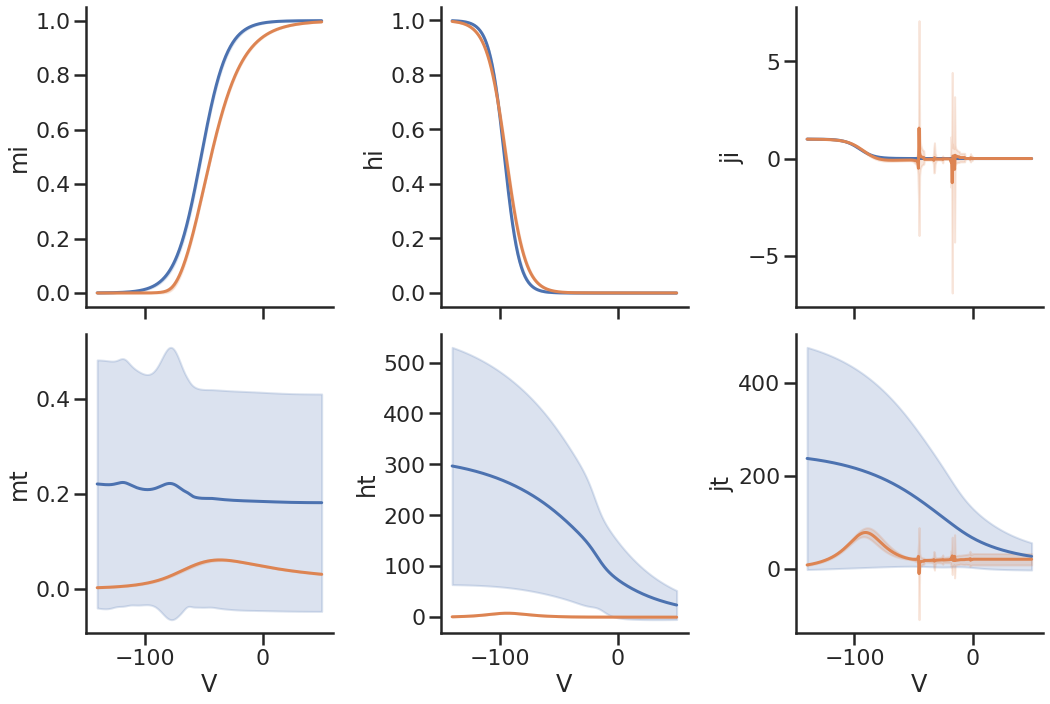

In [28]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_vars, cou_vars], 
                       [nyg, cou], 
                       [nyg_pars_existing, cou_pars],
                       figshape=(3,2))

In [29]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/ss_tau_existing_data.pdf')

In [30]:
std_vars = {'mi': 'ina.m_ss',
            'hi': 'ina.h_ss',
            'ji': 'ina.h_ss',
            'mt': 'ina.tau_m',
            'ht': 'ina.tau_h1',
            'jt': 'ina.tau_h2'}

In [47]:
N = 100

nyg_pars = df_nyg.sample(n=N, weights=w_nyg, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(N))])
nyg_pars = nyg_pars.to_dict(orient='records')

cou_pars_m = df_cou_m.sample(n=N, weights=w_cou_m, replace=True)
cou_pars_m = cou_pars_m.set_index([pd.Index(range(N))])
cou_pars_h = df_cou_h.sample(n=N, weights=w_cou_h, replace=True)
cou_pars_h = cou_pars_h.set_index([pd.Index(range(N))])
cou_pars_j = df_cou_j.sample(n=N, weights=w_cou_j, replace=True)
cou_pars_j = cou_pars_j.set_index([pd.Index(range(N))])
cou_pars = pd.concat([cou_pars_m,cou_pars_h,cou_pars_j],axis=1).to_dict(orient='records')

std_pars = df_sta.sample(n=N, weights=w_sta, replace=True)
std_pars = std_pars.set_index([pd.Index(range(N))])
std_pars = std_pars.to_dict(orient='records')

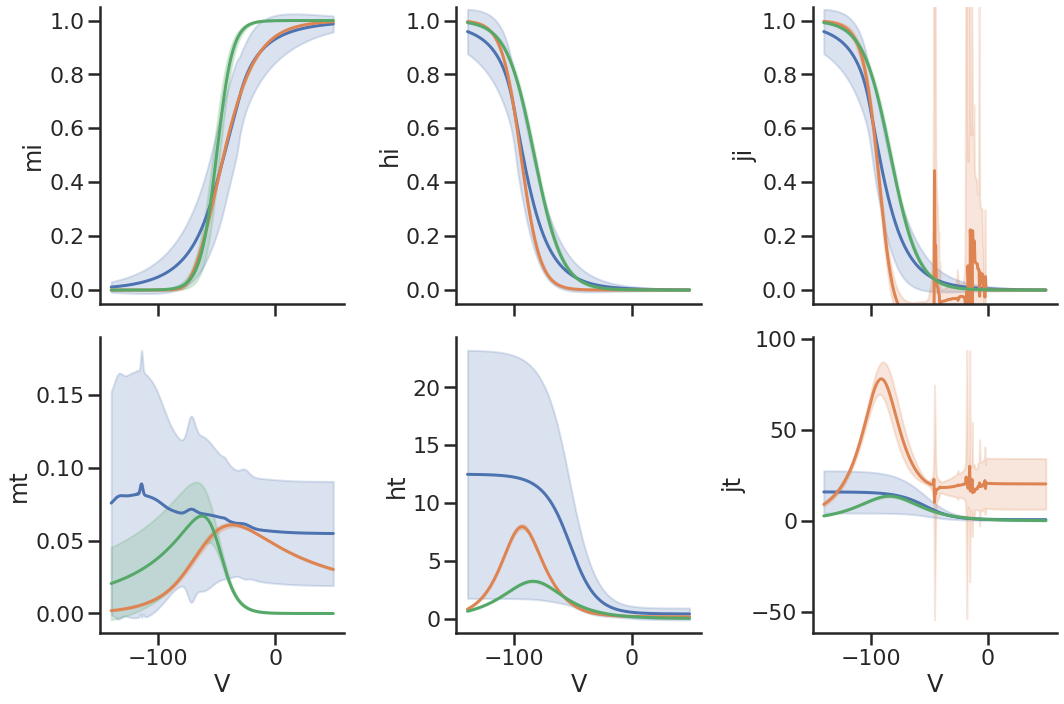

In [48]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_vars, cou_vars, std_vars], 
                       [nyg, cou, std], 
                       [nyg_pars, cou_pars, std_pars],
                       figshape=(3,2))
for ax in ax[0][:]:
    ax.set_ylim(-0.05, 1.05)

In [49]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/gates.pdf')